In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

import shap


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/creditcard.csv")

df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.shape


(284807, 31)

Data Cleaning


Check Missing Values

In [ ]:
df.isnull().sum()


,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


Check and Remove Duplicates

In [ ]:
df.duplicated().sum()


np.int64(1081)

In [ ]:
df = df.drop_duplicates()


Outlier Detection and handling(Transaction Amount)

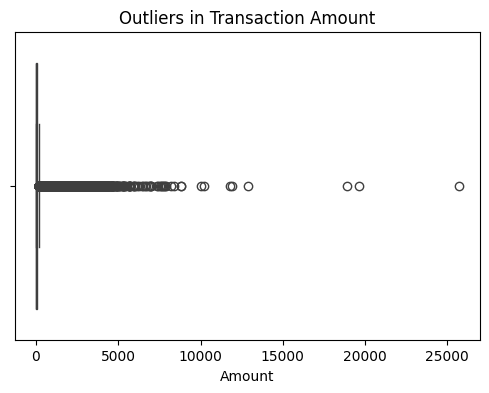

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df["Amount"])
plt.title("Outliers in Transaction Amount")
plt.show()

In [ ]:
df['Amount_log'] = np.log1p(df['Amount'])


Scaling Numerical Features

In [ ]:
scaler = StandardScaler()

df["Amount_scaled"] = scaler.fit_transform(df[["Amount_log"]])
df["Time_scaled"] = scaler.fit_transform(df[["Time"]])


Binning

In [ ]:
df["Time_bin"] = pd.cut(
    df["Time"],
    bins=4,
    labels=["Very Early", "Early", "Mid", "Late"]
)


In [ ]:
df = pd.get_dummies(df, columns=["Time_bin"], drop_first=True)


Domain-Derived Features

In [ ]:

df["High_Amount"] = (df["Amount"] > 200).astype(int)


Class Distribution

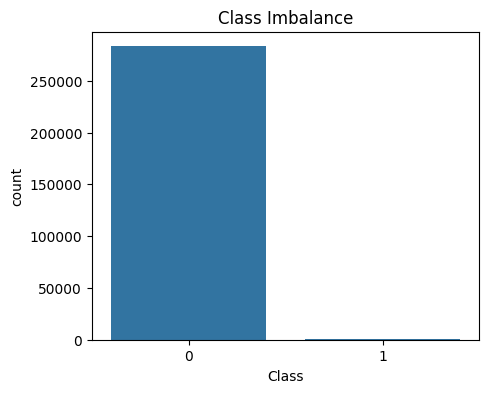

In [ ]:
plt.figure(figsize=(5,4))
sns.countplot(x="Class", data=df)
plt.title("Class Imbalance")
plt.show()


Amount vs Fraud

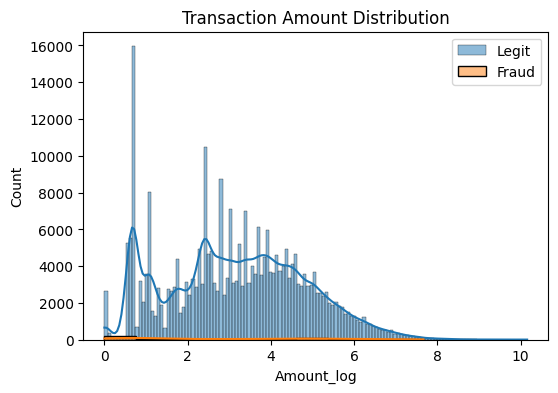

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(df[df["Class"] == 0]["Amount_log"], label="Legit", kde=True)
sns.histplot(df[df["Class"] == 1]["Amount_log"], label="Fraud", kde=True)
plt.legend()
plt.title("Transaction Amount Distribution")
plt.show()


Feature Relationships (Correlation)

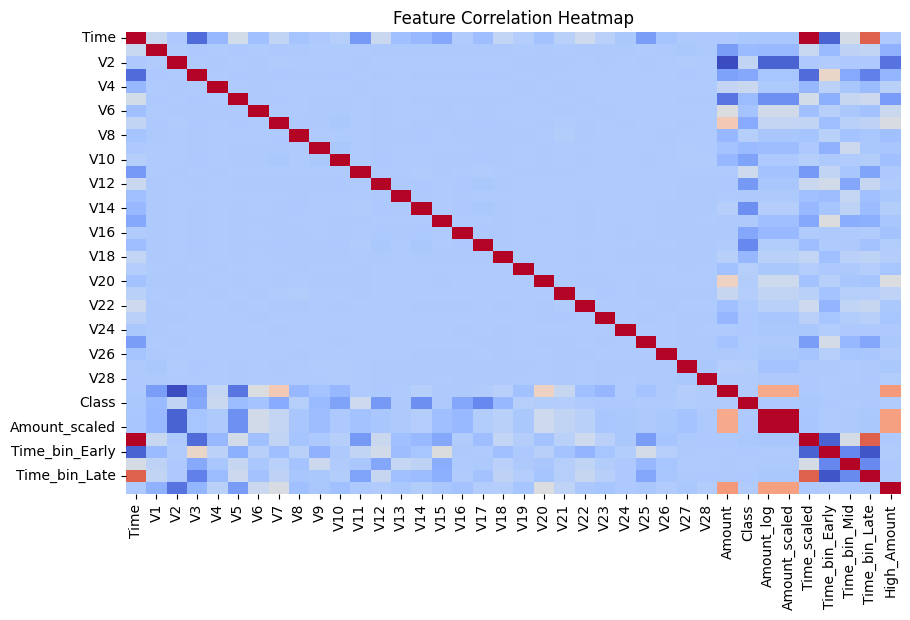

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), cmap="coolwarm", cbar=False)
plt.title("Feature Correlation Heatmap")
plt.show()


Model-Based Feature Importance (Random Forest)


In [ ]:
X = df.drop(columns=["Class"])
y = df["Class"]

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)


RandomForestClassifier(random_state=42)

In [ ]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10)


,0
V17,0.152978
V12,0.130087
V14,0.118896
V10,0.075983
V16,0.073516
V11,0.072535
V18,0.032222
V9,0.028588
V7,0.028024
V4,0.024471


SHAP Explainability

In [ ]:
import shap
explainer = shap.TreeExplainer(rf)
X_sampled = X.sample(1000, random_state=42)
shap_values = explainer.shap_values(X_sampled)

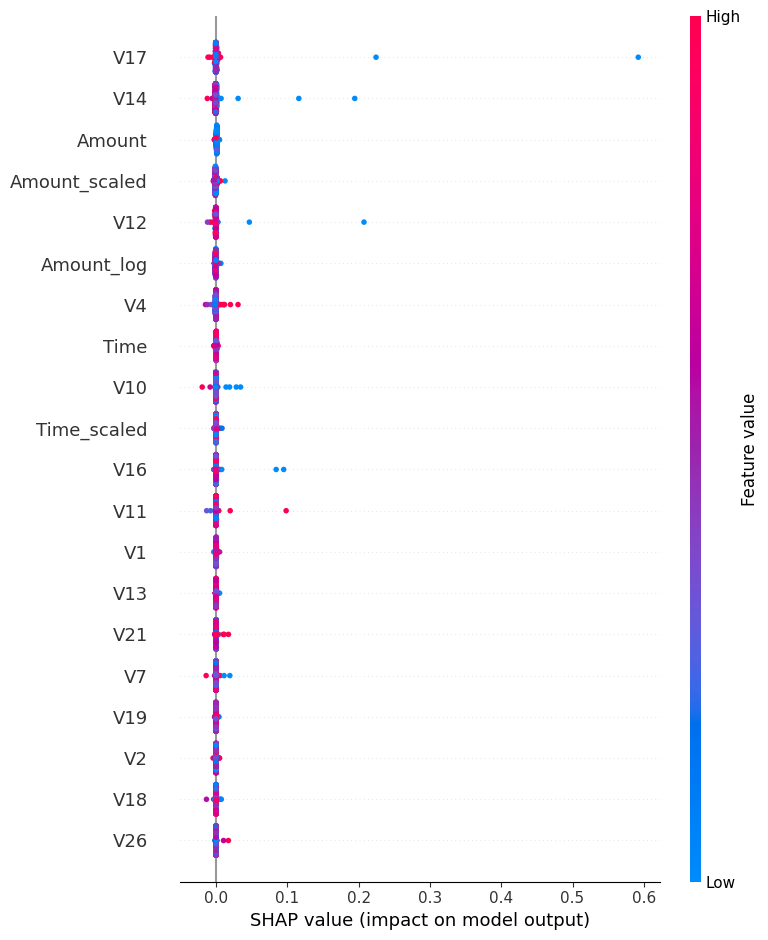

In [ ]:
import shap
shap.summary_plot(shap_values[:, :, 1], X_sampled)

Feature Selection
Method Used: Filter Method (ANOVA)

In [ ]:
selector = SelectKBest(score_func=f_classif, k=15)
X_selected = selector.fit_transform(X, y)


In [ ]:
selected_features = X.columns[selector.get_support()]
selected_features


Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12',
       'V14', 'V16', 'V17', 'V18'],
      dtype='object')

PCA for Variance Reduction

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_selected)


In [ ]:
print("Explained variance:", pca.explained_variance_ratio_)


Explained variance: [0.16203913 0.11576529]


PCA Visualisation

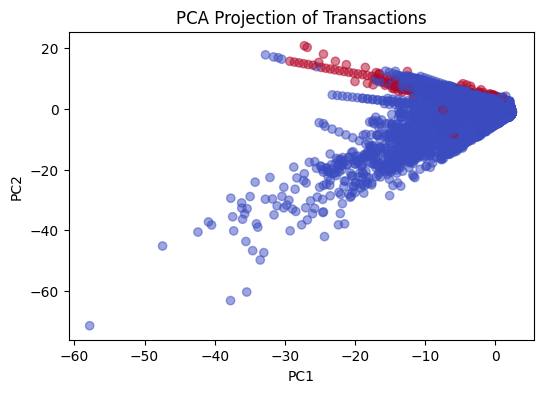

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="coolwarm", alpha=0.5)
plt.title("PCA Projection of Transactions")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


Model Implementation & Evaluations

In [ ]:
X = df.drop(columns=["Class"])
y = df["Class"]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42)

In [ ]:
#handle class imbalances
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

1. Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42)

log_model.fit(X_train_res, y_train_res)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)


In [ ]:
log_model = LogisticRegression(
    max_iter=1000,
    solver="lbfgs",
    class_weight="balanced",
    tol=1e-3,
    random_state=42)

log_model.fit(X_train_res_scaled, y_train_res)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   tol=0.001)

2. Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(
    max_depth=10,
    class_weight="balanced",
    random_state=42)

dt_model.fit(X_train_res, y_train_res)


DecisionTreeClassifier(class_weight='balanced', max_depth=10, random_state=42)

3. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=12,
    class_weight="balanced",
    random_state=42)

rf_model.fit(X_train_res, y_train_res)

RandomForestClassifier(class_weight='balanced', max_depth=12, random_state=42)

4. XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    eval_metric="logloss",
    random_state=42)

xgb_model.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

Evaluate all models

In [ ]:
#defining the evaluation and then running it
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

def evaluate(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\n{name}")
    print(classification_report(y_test, y_pred))

    auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)

    return {
        "Model": name,
        "Accuracy": acc,
        "ROC-AUC": auc    }


In [ ]:
results = []

results.append(evaluate(log_model, X_test, y_test, "Logistic Regression"))
results.append(evaluate(dt_model, X_test, y_test, "Decision Tree"))
results.append(evaluate(rf_model, X_test, y_test, "Random Forest"))
results.append(evaluate(xgb_model, X_test, y_test, "XGBoost"))

results_df = pd.DataFrame(results)
results_df

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(



Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56651
           1       0.01      0.06      0.02        95

    accuracy                           0.99     56746
   macro avg       0.51      0.53      0.51     56746
weighted avg       1.00      0.99      0.99     56746


Decision Tree
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56651
           1       0.13      0.80      0.22        95

    accuracy                           0.99     56746
   macro avg       0.56      0.90      0.61     56746
weighted avg       1.00      0.99      0.99     56746


Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.77      0.79      0.78        95

    accuracy                           1.00     56746
   macro avg       0.88      0.89      0.89     56746
weighted avg       1.00

,Model,Accuracy,ROC-AUC
0,Logistic Regression,0.991083,0.576482
1,Decision Tree,0.990361,0.891084
2,Random Forest,0.999242,0.975786
3,XGBoost,0.999366,0.976485


Ethical AI & Bias Audit

In [ ]:
!pip install shap

In [ ]:
import shap
import matplotlib.pyplot as plt

In [ ]:
#proceed with model selected
# Ensure all columns in X_train and X_test are numerical (float64) for SHAP explainer compatibility
X_train_for_shap = X_train.astype(float)
X_test_for_shap = X_test.astype(float)

explainer = shap.Explainer(xgb_model, X_train_for_shap)
shap_values = explainer(X_test_for_shap)

100%|===================| 56666/56746 [10:22<00:00]       

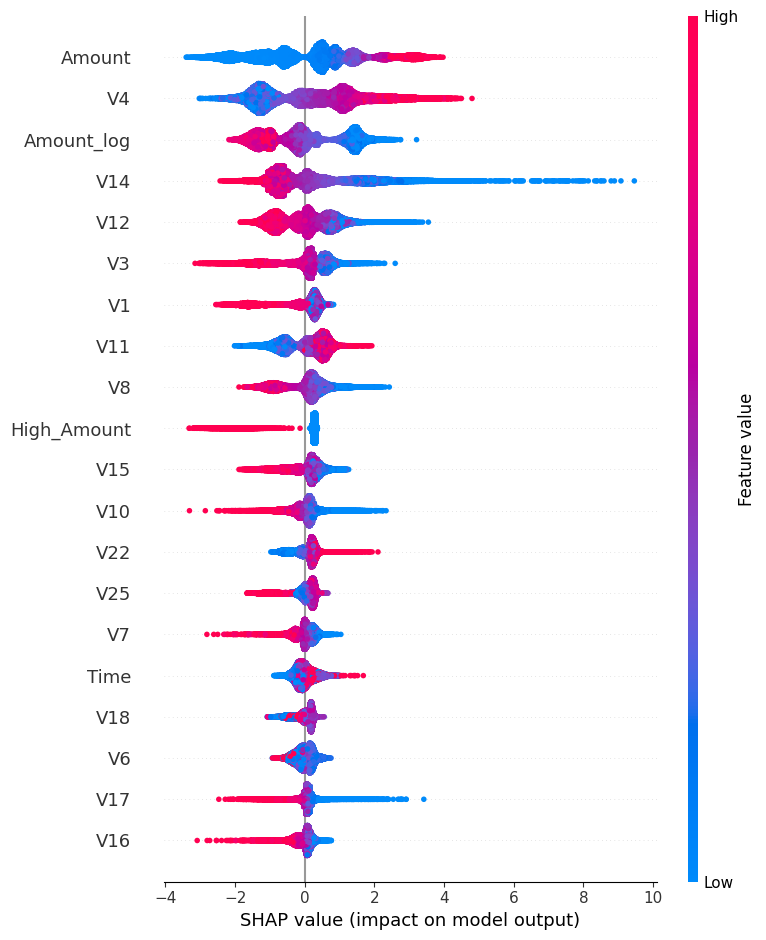

In [ ]:
shap.summary_plot(shap_values, X_test)

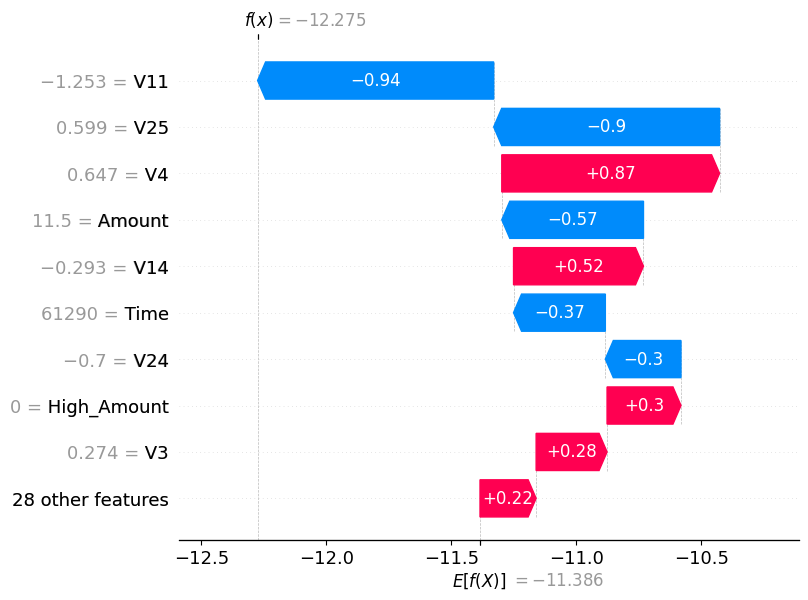

In [ ]:
i = 0
shap.plots.waterfall(shap_values[i])

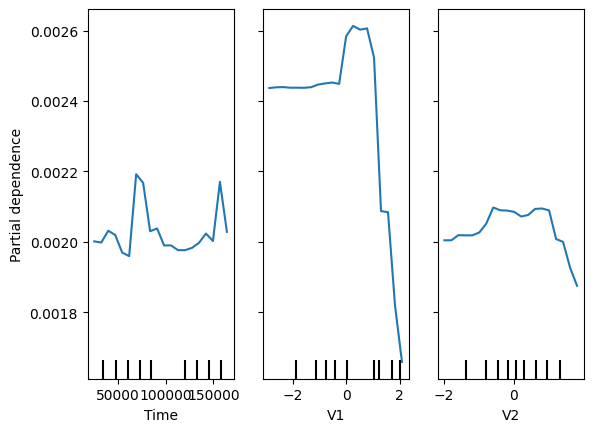

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    xgb_model, X_train, features=[0, 1, 2], grid_resolution=20)
plt.show()


Model class imbalance

In [ ]:
y.value_counts(normalize=True)

,proportion
Class,
0,0.998333
1,0.001667


Check for overfitting

In [ ]:
from sklearn.metrics import roc_auc_score

print("Train AUC:", roc_auc_score(y_train, xgb_model.predict_proba(X_train)[:,1]))
print("Test AUC:", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1]))


Train AUC: 1.0
Test AUC: 0.9764852016362418


Check for leakage

In [ ]:
assert 'target' not in X.columns